<a href="https://colab.research.google.com/github/dslmllab/dSL-Lab-Coding-Challenge/blob/main/2_word_embeddings_and_vectorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word Embeddings and Text Vectorization

## Learning Objectives

By the end of this notebook, you will be able to:

1. **Understand vector space models** and their importance in NLP
2. **Implement various text vectorization techniques** (BoW, TF-IDF, N-grams)
3. **Work with pre-trained word embeddings** (Word2Vec, GloVe, FastText)
4. **Train custom word embeddings** for domain-specific tasks
5. **Explore contextual embeddings** and their advantages
6. **Evaluate embedding quality** using various metrics
7. **Apply embeddings to downstream tasks** like similarity and classification

## Introduction

Text vectorization is the process of converting text into numerical representations that machine learning algorithms can work with. This is fundamental to NLP because computers can only process numbers, not raw text.

### Why Vector Representations Matter:
- **Mathematical Operations**: Enable arithmetic operations on text
- **Similarity Computation**: Calculate semantic similarity between words/documents
- **Machine Learning**: Serve as input features for ML models
- **Semantic Understanding**: Capture meaning and relationships in text

### Evolution of Text Representations:
1. **Sparse Representations**: One-hot encoding, Bag of Words, TF-IDF
2. **Dense Representations**: Word2Vec, GloVe, FastText
3. **Contextual Representations**: BERT, GPT, RoBERTa

## 1. Setup and Imports

In [1]:
# Install required packages
!pip3 install numpy pandas matplotlib seaborn nltk spacy scikit-learn gensim tqdm


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 24.0 MB 6.4 MB/s eta 0:00:01
     |████████████████████████████████| 14.0 MB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 780 kB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.5 MB 6.6 MB/s eta 0:00:01
  distutils: /private/var/folders/p1/t2xwmgqd5q168gcw8dxh9z680000gn/T/pip-build-env-vrefluk5/normal/lib/python3.9/site-packages
  sysconfig: /Library/Python/3.9/site-packages
  distutils: /private/var/folders/p1/t2xwmgqd5q168gcw8dxh9z680000gn/T/pip-build-env-vrefluk5/normal/lib/python3.9/site-packages
  sysconfig: /Library/Python/3.9/site-packages
  user = False
  home = None
  root = None
  prefix = '/private/var/folders/p1/t2xwmgqd5q168gcw8dxh9z680000gn/T/pip-build-env-vrefluk5/normal'
  distutils: /private/var/folders/p1/t2xwmgqd5q168gcw8dxh9z680000gn/T/pip-build-env-vrefluk5/overlay/lib/python3.9/site-packages
  sysconfig: /Library/Pyth

In [2]:

import spacy
import nltk

try:
    spacy.load("en_core_web_sm")
except OSError:
    !python -m spacy download en_core_web_sm





for item in ['punkt', 'stopwords']:
    nltk.download(item, quiet=True)

/Users/expansionislife/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import spacy

# Scikit-learn for traditional methods
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Word embeddings
import gensim
from gensim.models import Word2Vec, KeyedVectors, FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Plotting
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Download required NLTK data
nltk_downloads = ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger', 'maxent_ne_chunker', 'words','punkt_tab','averaged_perceptron_tagger_eng']

for item in nltk_downloads:
    try:
        nltk.download(item, quiet=True)
    except:
        print(f"Could not download {item}")

print("Setup completed successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Gensim version: {gensim.__version__}")

Setup completed successfully!
NumPy version: 1.26.4
Gensim version: 4.3.3


## 2. Sample Data Preparation

In [4]:
# Create sample corpus for embeddings training
sample_corpus = [
    "The cat sat on the mat and looked around.",
    "A dog ran quickly through the park.",
    "The quick brown fox jumps over the lazy dog.",
    "Birds fly high in the blue sky.",
    "Fish swim deep in the ocean water.",
    "The sun shines brightly during the day.",
    "Stars twinkle in the dark night sky.",
    "Flowers bloom beautifully in spring.",
    "Trees grow tall in the forest.",
    "Rivers flow towards the sea.",
    "Mountains stand majestically against the horizon.",
    "Children play happily in the playground.",
    "Students study diligently in the library.",
    "Teachers explain concepts clearly to students.",
    "Books contain knowledge and wisdom.",
    "Computers process information very quickly.",
    "Internet connects people around the world.",
    "Mobile phones are essential communication tools.",
    "Cars drive on roads and highways.",
    "Planes fly through clouds in the sky.",
    "Music brings joy to many people.",
    "Art expresses creativity and emotions.",
    "Sports promote health and fitness.",
    "Food provides energy and nutrition.",
    "Water is essential for all life."
]

# Create different categories for classification tasks
categorized_corpus = {
    'animals': [
        "The cat sat on the mat peacefully.",
        "A dog ran quickly through the park.",
        "Birds fly high in the blue sky.",
        "Fish swim deep in the ocean water.",
        "Elephants are large gray mammals.",
        "Lions are fierce predators in Africa.",
        "Dolphins are intelligent marine animals.",
        "Bears hibernate during winter months."
    ],
    'technology': [
        "Computers process information very quickly.",
        "Internet connects people around the world.",
        "Mobile phones are essential communication tools.",
        "Artificial intelligence is advancing rapidly.",
        "Robots can perform complex tasks.",
        "Software applications help users daily.",
        "Digital cameras capture high-quality images.",
        "Virtual reality creates immersive experiences."
    ],
    'nature': [
        "The sun shines brightly during the day.",
        "Stars twinkle in the dark night sky.",
        "Flowers bloom beautifully in spring.",
        "Trees grow tall in the forest.",
        "Rivers flow towards the sea.",
        "Mountains stand majestically against the horizon.",
        "Rain falls gently on the earth.",
        "Wind blows softly through the leaves."
    ]
}

# Flatten categorized corpus
all_categorized_texts = []
all_labels = []
for category, texts in categorized_corpus.items():
    all_categorized_texts.extend(texts)
    all_labels.extend([category] * len(texts))

print(f"Sample corpus: {len(sample_corpus)} documents")
print(f"Categorized corpus: {len(all_categorized_texts)} documents in {len(categorized_corpus)} categories")
print(f"Categories: {list(categorized_corpus.keys())}")

# Display sample texts
print("\nSample texts:")
for i, text in enumerate(sample_corpus[:5]):
    print(f"{i+1}. {text}")

Sample corpus: 25 documents
Categorized corpus: 24 documents in 3 categories
Categories: ['animals', 'technology', 'nature']

Sample texts:
1. The cat sat on the mat and looked around.
2. A dog ran quickly through the park.
3. The quick brown fox jumps over the lazy dog.
4. Birds fly high in the blue sky.
5. Fish swim deep in the ocean water.


## 3. Traditional Vectorization Methods

### 3.1 Bag of Words (BoW)

In [7]:
class BagOfWordsVectorizer:
    """Custom Bag of Words implementation"""

    def __init__(self, max_features=None, lowercase=True, stop_words=None):
        self.max_features = max_features
        self.lowercase = lowercase
        self.stop_words = set(stop_words) if stop_words else set()
        self.vocabulary_ = {}
        self.feature_names_ = []

    def _preprocess_text(self, text):
        """Basic text preprocessing"""
        if self.lowercase:
            text = text.lower()

        # Simple tokenization
        tokens = word_tokenize(text)

        # Remove stop words
        if self.stop_words:
            tokens = [token for token in tokens if token not in self.stop_words]

        # Remove punctuation
        tokens = [token for token in tokens if token.isalpha()]

        return tokens

    def fit(self, documents):
        """Build vocabulary from documents"""
        word_counts = Counter()

        for doc in documents:
            tokens = self._preprocess_text(doc)
            word_counts.update(tokens)

        # Select top features if max_features is specified
        if self.max_features:
            most_common = word_counts.most_common(self.max_features)
            vocabulary = [word for word, count in most_common]
        else:
            vocabulary = list(word_counts.keys())

        # Create vocabulary mapping
        self.vocabulary_ = {word: idx for idx, word in enumerate(vocabulary)}
        self.feature_names_ = vocabulary

        return self

    def transform(self, documents):
        """Transform documents to BoW vectors"""
        vectors = np.zeros((len(documents), len(self.vocabulary_)))

        for doc_idx, doc in enumerate(documents):
            tokens = self._preprocess_text(doc)
            token_counts = Counter(tokens)

            for token, count in token_counts.items():
                if token in self.vocabulary_:
                    word_idx = self.vocabulary_[token]
                    vectors[doc_idx, word_idx] = count

        return vectors

    def fit_transform(self, documents):
        """Fit and transform in one step"""
        return self.fit(documents).transform(documents)

# Test custom BoW
print("Custom Bag of Words Vectorizer:")
print("=" * 40)

custom_bow = BagOfWordsVectorizer(max_features=20, stop_words=stopwords.words('english'))
bow_vectors = custom_bow.fit_transform(sample_corpus[:5])

print(f"Vocabulary size: {len(custom_bow.vocabulary_)}")
print(f"Vector shape: {bow_vectors.shape}")
print(f"Feature names: {custom_bow.feature_names_[:10]}...")

# Display first document vector
print(f"\nFirst document: '{sample_corpus[0]}'")
print(f"Vector: {bow_vectors[0][:10]}...")

# Compare with sklearn's CountVectorizer
print("\nCompare with sklearn's CountVectorizer:")
sklearn_bow = CountVectorizer(max_features=20, stop_words='english', lowercase=True)
sklearn_vectors = sklearn_bow.fit_transform(sample_corpus[:5]).toarray()

print(f"Sklearn vocabulary size: {len(sklearn_bow.vocabulary_)}")
print(f"Sklearn vector shape: {sklearn_vectors.shape}")

Custom Bag of Words Vectorizer:
Vocabulary size: 20
Vector shape: (5, 20)
Feature names: ['dog', 'cat', 'sat', 'mat', 'looked', 'around', 'ran', 'quickly', 'park', 'quick']...

First document: 'The cat sat on the mat and looked around.'
Vector: [0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]...

Compare with sklearn's CountVectorizer:
Sklearn vocabulary size: 20
Sklearn vector shape: (5, 20)


### 3.2 TF-IDF Vectorization

Custom TF-IDF Vectorizer:
Vocabulary size: 20
Vector shape: (8, 20)
Feature names: ['dog', 'sky', 'cat', 'sat', 'mat', 'looked', 'around', 'ran', 'quickly', 'park']

Top IDF values:
cat: 1.386
sat: 1.386
mat: 1.386
looked: 1.386
around: 1.386
ran: 1.386
quickly: 1.386
park: 1.386
quick: 1.386
brown: 1.386

Sklearn TF-IDF shape: (8, 20)


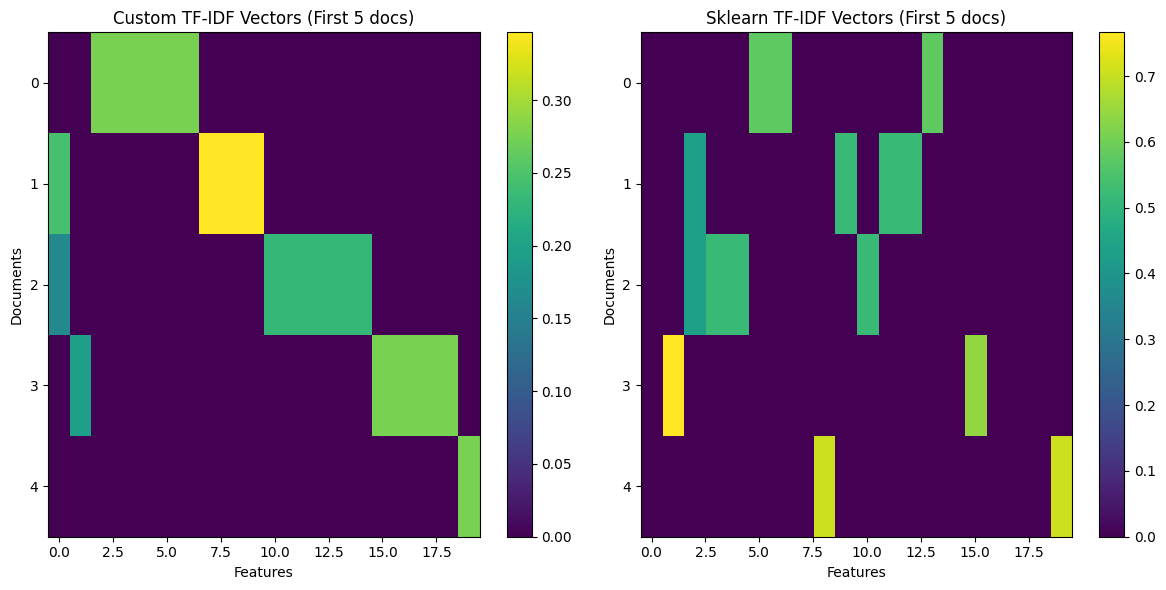

In [8]:
class TFIDFVectorizer:
    """Custom TF-IDF implementation"""

    def __init__(self, max_features=None, lowercase=True, stop_words=None):
        self.max_features = max_features
        self.lowercase = lowercase
        self.stop_words = set(stop_words) if stop_words else set()
        self.vocabulary_ = {}
        self.idf_ = {}
        self.feature_names_ = []

    def _preprocess_text(self, text):
        """Basic text preprocessing"""
        if self.lowercase:
            text = text.lower()

        tokens = word_tokenize(text)

        if self.stop_words:
            tokens = [token for token in tokens if token not in self.stop_words]

        tokens = [token for token in tokens if token.isalpha()]

        return tokens

    def fit(self, documents):
        """Build vocabulary and calculate IDF values"""
        # Build vocabulary
        word_counts = Counter()
        doc_word_sets = []

        for doc in documents:
            tokens = self._preprocess_text(doc)
            doc_word_set = set(tokens)
            doc_word_sets.append(doc_word_set)
            word_counts.update(tokens)

        # Select vocabulary
        if self.max_features:
            most_common = word_counts.most_common(self.max_features)
            vocabulary = [word for word, count in most_common]
        else:
            vocabulary = list(word_counts.keys())

        self.vocabulary_ = {word: idx for idx, word in enumerate(vocabulary)}
        self.feature_names_ = vocabulary

        # Calculate IDF values
        num_docs = len(documents)
        for word in vocabulary:
            # Count documents containing the word
            doc_freq = sum(1 for doc_words in doc_word_sets if word in doc_words)
            # Calculate IDF
            self.idf_[word] = np.log(num_docs / (doc_freq + 1))  # +1 for smoothing

        return self

    def transform(self, documents):
        """Transform documents to TF-IDF vectors"""
        vectors = np.zeros((len(documents), len(self.vocabulary_)))

        for doc_idx, doc in enumerate(documents):
            tokens = self._preprocess_text(doc)
            token_counts = Counter(tokens)
            total_tokens = len(tokens)

            for token, count in token_counts.items():
                if token in self.vocabulary_:
                    word_idx = self.vocabulary_[token]
                    tf = count / total_tokens  # Term frequency
                    idf = self.idf_[token]     # Inverse document frequency
                    vectors[doc_idx, word_idx] = tf * idf

        return vectors

    def fit_transform(self, documents):
        """Fit and transform in one step"""
        return self.fit(documents).transform(documents)

# Test custom TF-IDF
print("Custom TF-IDF Vectorizer:")
print("=" * 40)

custom_tfidf = TFIDFVectorizer(max_features=20, stop_words=stopwords.words('english'))
tfidf_vectors = custom_tfidf.fit_transform(sample_corpus[:8])

print(f"Vocabulary size: {len(custom_tfidf.vocabulary_)}")
print(f"Vector shape: {tfidf_vectors.shape}")
print(f"Feature names: {custom_tfidf.feature_names_[:10]}")

# Show IDF values
print("\nTop IDF values:")
sorted_idf = sorted(custom_tfidf.idf_.items(), key=lambda x: x[1], reverse=True)[:10]
for word, idf_val in sorted_idf:
    print(f"{word}: {idf_val:.3f}")

# Compare with sklearn's TfidfVectorizer
sklearn_tfidf = TfidfVectorizer(max_features=20, stop_words='english')
sklearn_tfidf_vectors = sklearn_tfidf.fit_transform(sample_corpus[:8]).toarray()

print(f"\nSklearn TF-IDF shape: {sklearn_tfidf_vectors.shape}")

# Visualize TF-IDF vectors
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(tfidf_vectors[:5], cmap='viridis', aspect='auto')
plt.title('Custom TF-IDF Vectors (First 5 docs)')
plt.xlabel('Features')
plt.ylabel('Documents')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(sklearn_tfidf_vectors[:5], cmap='viridis', aspect='auto')
plt.title('Sklearn TF-IDF Vectors (First 5 docs)')
plt.xlabel('Features')
plt.ylabel('Documents')
plt.colorbar()

plt.tight_layout()
plt.show()

### 3.3 N-gram Features

N-gram Analysis:

1-grams (Top 10):
  'the': 12
  'in': 5
  'dog': 2
  'sky': 2
  'cat': 1
  'sat': 1
  'on': 1
  'mat': 1
  'and': 1
  'looked': 1

2-grams (Top 10):
  'in the': 4
  'the cat': 1
  'cat sat': 1
  'sat on': 1
  'on the': 1
  'the mat': 1
  'mat and': 1
  'and looked': 1
  'looked around': 1
  'a dog': 1

3-grams (Top 10):
  'the cat sat': 1
  'cat sat on': 1
  'sat on the': 1
  'on the mat': 1
  'the mat and': 1
  'mat and looked': 1
  'and looked around': 1
  'a dog ran': 1
  'dog ran quickly': 1
  'ran quickly through': 1

N-gram Vectorization with sklearn:
unigrams       : 42 features
bigrams        : 34 features
trigrams       : 24 features
uni+bigrams    : 50 features
uni+bi+trigrams: 50 features

Sample features:
unigrams       : ['beautifully', 'birds', 'bloom', 'blue', 'brightly', 'brown', 'cat', 'dark', 'day', 'deep']
bigrams        : ['beautifully spring', 'birds fly', 'bloom beautifully', 'blue sky', 'brightly day', 'brown fox', 'cat sat', 'dark night', 'deep

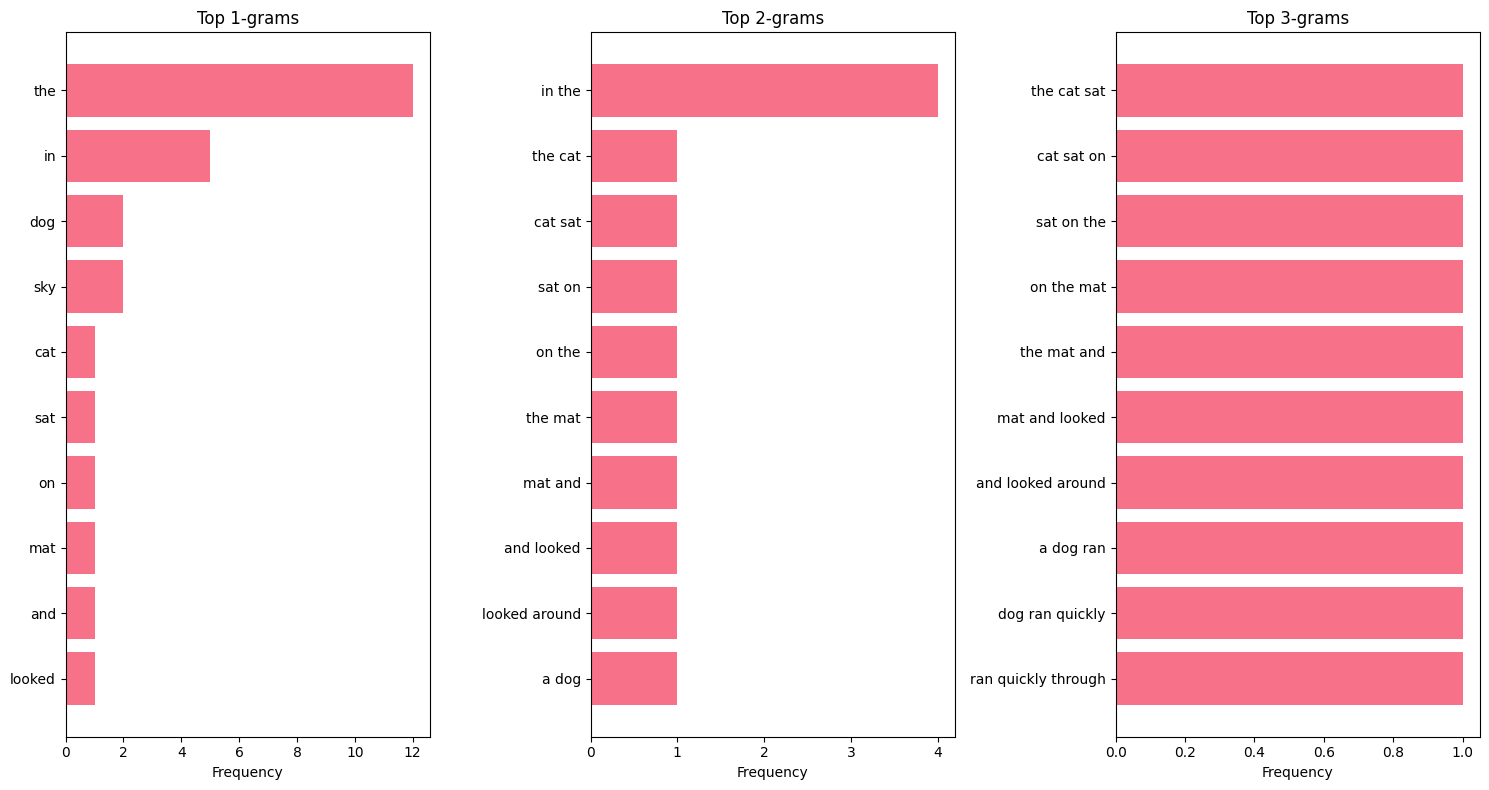

In [12]:
def create_ngrams(text, n):
    """Create n-grams from text"""
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha()]

    ngrams = []
    for i in range(len(tokens) - n + 1):
        ngram = ' '.join(tokens[i:i+n])
        ngrams.append(ngram)

    return ngrams

def analyze_ngrams(corpus, max_n=3):
    """Analyze n-grams in corpus"""
    ngram_analysis = {}

    for n in range(1, max_n + 1):
        all_ngrams = []
        for text in corpus:
            ngrams = create_ngrams(text, n)
            all_ngrams.extend(ngrams)

        ngram_counts = Counter(all_ngrams)
        ngram_analysis[n] = ngram_counts

    return ngram_analysis

# Analyze n-grams in sample corpus
print("N-gram Analysis:")
print("=" * 30)

ngram_analysis = analyze_ngrams(sample_corpus[:10])

for n, ngram_counts in ngram_analysis.items():
    print(f"\n{n}-grams (Top 10):")
    for ngram, count in ngram_counts.most_common(10):
        print(f"  '{ngram}': {count}")

# Use sklearn for n-gram vectorization
print("\nN-gram Vectorization with sklearn:")
print("=" * 40)

# Different n-gram configurations
configs = {
    'unigrams': (1, 1),
    'bigrams': (2, 2),
    'trigrams': (3, 3),
    'uni+bigrams': (1, 2),
    'uni+bi+trigrams': (1, 3)
}

vectorizer_results = {}

for name, ngram_range in configs.items():
    vectorizer = TfidfVectorizer(
        ngram_range=ngram_range,
        max_features=50,
        stop_words='english'
    )

    vectors = vectorizer.fit_transform(sample_corpus[:10])
    vectorizer_results[name] = {
        'vectorizer': vectorizer,
        'vectors': vectors,
        'feature_names': vectorizer.get_feature_names_out()
    }

    print(f"{name:15}: {vectors.shape[1]} features")

# Show sample features for different n-gram ranges
print("\nSample features:")
for name, results in vectorizer_results.items():
    features = results['feature_names'][:10]
    print(f"{name:15}: {list(features)}")

# Visualize n-gram frequency
plt.figure(figsize=(15, 8))

for i, (n, ngram_counts) in enumerate(ngram_analysis.items(), 1):
    plt.subplot(1, 3, i)

    top_ngrams = ngram_counts.most_common(10)
    ngrams, counts = zip(*top_ngrams)

    plt.barh(range(len(ngrams)), counts)
    plt.yticks(range(len(ngrams)), [ngram[:20] + '...' if len(ngram) > 20 else ngram for ngram in ngrams])
    plt.xlabel('Frequency')
    plt.title(f'Top {n}-grams')
    plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

## 4. Word2Vec Embeddings

In [13]:
# Prepare corpus for Word2Vec training
def preprocess_for_word2vec(corpus):
    """Preprocess corpus for Word2Vec training"""
    processed_corpus = []

    for text in corpus:
        # Tokenize and clean
        tokens = word_tokenize(text.lower())
        tokens = [token for token in tokens if token.isalpha() and len(token) > 1]
        processed_corpus.append(tokens)

    return processed_corpus

# Prepare training data
training_data = preprocess_for_word2vec(sample_corpus)

print("Word2Vec Training:")
print("=" * 30)
print(f"Training corpus: {len(training_data)} sentences")
print(f"Sample sentence: {training_data[0]}")

# Train Word2Vec models with different architectures
word2vec_models = {}

# Skip-gram model
sg_model = Word2Vec(
    sentences=training_data,
    vector_size=100,
    window=5,
    min_count=1,
    sg=1,  # Skip-gram
    epochs=100,
    seed=42
)
word2vec_models['skip-gram'] = sg_model

# CBOW model
cbow_model = Word2Vec(
    sentences=training_data,
    vector_size=100,
    window=5,
    min_count=1,
    sg=0,  # CBOW
    epochs=100,
    seed=42
)
word2vec_models['cbow'] = cbow_model

print(f"\nTrained models: {list(word2vec_models.keys())}")

# Analyze vocabulary
for name, model in word2vec_models.items():
    vocab_size = len(model.wv.key_to_index)
    print(f"{name:10}: {vocab_size} words in vocabulary")

# Test word similarities
print("\nWord Similarities (Skip-gram model):")
print("=" * 40)

test_words = ['cat', 'dog', 'sun', 'sky', 'water']
sg_model = word2vec_models['skip-gram']

for word in test_words:
    if word in sg_model.wv:
        try:
            similar_words = sg_model.wv.most_similar(word, topn=3)
            print(f"{word:8}: {similar_words}")
        except:
            print(f"{word:8}: No similar words found")
    else:
        print(f"{word:8}: Not in vocabulary")

# Word arithmetic examples
print("\nWord Arithmetic Examples:")
print("=" * 30)

try:
    # Example: sky - day + night ≈ stars
    result = sg_model.wv.most_similar(
        positive=['sky', 'night'],
        negative=['day'],
        topn=3
    )
    print(f"sky - day + night = {result}")
except Exception as e:
    print(f"Word arithmetic failed: {e}")

# Get word vectors
print("\nWord Vectors:")
print("=" * 20)

for word in ['cat', 'dog', 'sun']:
    if word in sg_model.wv:
        vector = sg_model.wv[word]
        print(f"{word}: shape {vector.shape}, sample: {vector[:5]}")

# Compare Skip-gram vs CBOW
print("\nSkip-gram vs CBOW Comparison:")
print("=" * 35)

test_word = 'cat'
if test_word in sg_model.wv and test_word in cbow_model.wv:
    sg_vector = sg_model.wv[test_word]
    cbow_vector = cbow_model.wv[test_word]

    # Calculate cosine similarity between the vectors
    similarity = cosine_similarity([sg_vector], [cbow_vector])[0][0]
    print(f"Vector similarity for '{test_word}': {similarity:.4f}")

    # Compare similar words
    print(f"\nSimilar words to '{test_word}':")
    try:
        sg_similar = sg_model.wv.most_similar(test_word, topn=3)
        cbow_similar = cbow_model.wv.most_similar(test_word, topn=3)
        print(f"Skip-gram: {sg_similar}")
        print(f"CBOW:      {cbow_similar}")
    except:
        print("Could not compute similar words")

Word2Vec Training:
Training corpus: 25 sentences
Sample sentence: ['the', 'cat', 'sat', 'on', 'the', 'mat', 'and', 'looked', 'around']

Trained models: ['skip-gram', 'cbow']
skip-gram : 113 words in vocabulary
cbow      : 113 words in vocabulary

Word Similarities (Skip-gram model):
cat     : [('in', 0.8429120182991028), ('and', 0.8417391777038574), ('the', 0.8272002935409546)]
dog     : [('the', 0.8893165588378906), ('in', 0.8697004318237305), ('and', 0.8539904356002808)]
sun     : [('the', 0.8717945218086243), ('and', 0.8432212471961975), ('shines', 0.8422341346740723)]
sky     : [('the', 0.8881910443305969), ('and', 0.8869510889053345), ('in', 0.8603591322898865)]
water   : [('the', 0.85499507188797), ('and', 0.8357812166213989), ('essential', 0.8268567323684692)]

Word Arithmetic Examples:
sky - day + night = [('around', 0.7268168330192566), ('fish', 0.7200896739959717), ('brown', 0.7161770462989807)]

Word Vectors:
cat: shape (100,), sample: [ 0.01575757  0.00711737  0.00446429 -0

## 5. FastText Embeddings

In [14]:
# Train FastText model
print("FastText Training:")
print("=" * 25)

fasttext_model = FastText(
    sentences=training_data,
    vector_size=100,
    window=5,
    min_count=1,
    min_n=3,  # Minimum character n-gram
    max_n=6,  # Maximum character n-gram
    sg=1,     # Skip-gram
    epochs=100,
    seed=42
)

print(f"FastText vocabulary size: {len(fasttext_model.wv.key_to_index)}")

# Test FastText's ability to handle out-of-vocabulary words
print("\nOut-of-Vocabulary Word Handling:")
print("=" * 40)

# Test words (some may not be in training vocabulary)
test_oov_words = ['cats', 'dogs', 'flying', 'swimming', 'unknown_word']

for word in test_oov_words:
    # Word2Vec (Skip-gram)
    if word in sg_model.wv:
        w2v_status = "In vocabulary"
        w2v_vector = sg_model.wv[word]
    else:
        w2v_status = "OOV (Out of Vocabulary)"
        w2v_vector = None

    # FastText (can handle OOV through subword information)
    try:
        ft_vector = fasttext_model.wv[word]
        ft_status = "Vector generated"
    except:
        ft_status = "Failed"
        ft_vector = None

    print(f"{word:15} - Word2Vec: {w2v_status:20} FastText: {ft_status}")

# Compare similar words
print("\nSimilar Words Comparison (Word2Vec vs FastText):")
print("=" * 55)

comparison_words = ['cat', 'sun', 'water']

for word in comparison_words:
    print(f"\nWord: {word}")

    # Word2Vec similar words
    if word in sg_model.wv:
        try:
            w2v_similar = sg_model.wv.most_similar(word, topn=3)
            print(f"  Word2Vec:  {w2v_similar}")
        except:
            print(f"  Word2Vec:  No similar words")
    else:
        print(f"  Word2Vec:  Word not in vocabulary")

    # FastText similar words
    try:
        ft_similar = fasttext_model.wv.most_similar(word, topn=3)
        print(f"  FastText:  {ft_similar}")
    except:
        print(f"  FastText:  No similar words")

# Analyze character n-grams (FastText-specific)
print("\nCharacter N-grams Analysis:")
print("=" * 35)

def show_char_ngrams(word, min_n=3, max_n=6):
    """Show character n-grams for a word"""
    word = f"<{word}>"  # FastText adds boundary markers
    ngrams = []

    for n in range(min_n, max_n + 1):
        for i in range(len(word) - n + 1):
            ngrams.append(word[i:i+n])

    return ngrams

example_words = ['cat', 'running', 'beautiful']
for word in example_words:
    ngrams = show_char_ngrams(word)
    print(f"{word:10}: {ngrams[:10]}...")

# Save models for later use
print("\nSaving models...")
sg_model.save("word2vec_skipgram.model")
cbow_model.save("word2vec_cbow.model")
fasttext_model.save("fasttext.model")
print("Models saved successfully!")

FastText Training:
FastText vocabulary size: 113

Out-of-Vocabulary Word Handling:
cats            - Word2Vec: OOV (Out of Vocabulary) FastText: Vector generated
dogs            - Word2Vec: OOV (Out of Vocabulary) FastText: Vector generated
flying          - Word2Vec: OOV (Out of Vocabulary) FastText: Vector generated
swimming        - Word2Vec: OOV (Out of Vocabulary) FastText: Vector generated
unknown_word    - Word2Vec: OOV (Out of Vocabulary) FastText: Vector generated

Similar Words Comparison (Word2Vec vs FastText):

Word: cat
  Word2Vec:  [('in', 0.8429120182991028), ('and', 0.8417391777038574), ('the', 0.8272002935409546)]
  FastText:  [('around', 0.977989912033081), ('and', 0.9769847989082336), ('communication', 0.976850688457489)]

Word: sun
  Word2Vec:  [('the', 0.8717945218086243), ('and', 0.8432212471961975), ('shines', 0.8422341346740723)]
  FastText:  [('during', 0.9638324975967407), ('the', 0.9631109237670898), ('phones', 0.9608343839645386)]

Word: water
  Word2Vec:  [

## 6. Document Embeddings with Doc2Vec

In [15]:
# Prepare data for Doc2Vec
def prepare_doc2vec_data(corpus, labels=None):
    """Prepare tagged documents for Doc2Vec"""
    tagged_docs = []

    for i, doc in enumerate(corpus):
        tokens = word_tokenize(doc.lower())
        tokens = [token for token in tokens if token.isalpha()]

        # Create tag
        if labels:
            tag = f"{labels[i]}_{i}"
        else:
            tag = f"DOC_{i}"

        tagged_doc = TaggedDocument(words=tokens, tags=[tag])
        tagged_docs.append(tagged_doc)

    return tagged_docs

# Prepare training data
tagged_docs = prepare_doc2vec_data(all_categorized_texts, all_labels)

print("Doc2Vec Training:")
print("=" * 25)
print(f"Tagged documents: {len(tagged_docs)}")
print(f"Sample tagged doc: {tagged_docs[0]}")

# Train Doc2Vec models
doc2vec_models = {}

# PV-DM (Distributed Memory)
dm_model = Doc2Vec(
    documents=tagged_docs,
    vector_size=100,
    window=5,
    min_count=1,
    dm=1,  # PV-DM
    epochs=100,
    seed=42
)
doc2vec_models['PV-DM'] = dm_model

# PV-DBOW (Distributed Bag of Words)
dbow_model = Doc2Vec(
    documents=tagged_docs,
    vector_size=100,
    window=5,
    min_count=1,
    dm=0,  # PV-DBOW
    epochs=100,
    seed=42
)
doc2vec_models['PV-DBOW'] = dbow_model

print(f"\nTrained Doc2Vec models: {list(doc2vec_models.keys())}")

# Test document similarity
print("\nDocument Similarity Analysis:")
print("=" * 40)

def find_similar_documents(model, doc_id, topn=3):
    """Find similar documents using Doc2Vec"""
    try:
        similar_docs = model.dv.most_similar(doc_id, topn=topn)
        return similar_docs
    except:
        return []

# Test with a few documents
test_doc_indices = [0, 8, 16]  # Different categories

for model_name, model in doc2vec_models.items():
    print(f"\n{model_name} Model:")

    for idx in test_doc_indices:
        doc_tag = tagged_docs[idx].tags[0]
        original_text = all_categorized_texts[idx]
        original_label = all_labels[idx]

        similar_docs = find_similar_documents(model, doc_tag, topn=2)

        print(f"\n  Original ({original_label}): {original_text[:50]}...")
        print(f"  Similar documents:")

        for similar_tag, similarity in similar_docs:
            # Extract index from tag
            similar_idx = int(similar_tag.split('_')[-1])
            similar_text = all_categorized_texts[similar_idx]
            similar_label = all_labels[similar_idx]

            print(f"    {similarity:.3f} ({similar_label}): {similar_text[:40]}...")

# Infer vector for new document
print("\nInferring Vector for New Document:")
print("=" * 45)

new_doc = "The computer processes data very quickly and efficiently."
new_tokens = word_tokenize(new_doc.lower())
new_tokens = [token for token in new_tokens if token.isalpha()]

print(f"New document: {new_doc}")

for model_name, model in doc2vec_models.items():
    # Infer vector
    inferred_vector = model.infer_vector(new_tokens)

    # Find most similar documents
    similar_docs = model.dv.most_similar([inferred_vector], topn=3)

    print(f"\n{model_name} - Most similar documents:")
    for doc_tag, similarity in similar_docs:
        doc_idx = int(doc_tag.split('_')[-1])
        doc_text = all_categorized_texts[doc_idx]
        doc_label = all_labels[doc_idx]
        print(f"  {similarity:.3f} ({doc_label}): {doc_text[:50]}...")

# Get document vectors
print("\nDocument Vector Analysis:")
print("=" * 30)

dm_model = doc2vec_models['PV-DM']

# Get vectors for documents from different categories
category_vectors = defaultdict(list)

for i, (text, label) in enumerate(zip(all_categorized_texts, all_labels)):
    doc_tag = tagged_docs[i].tags[0]
    if doc_tag in dm_model.dv:
        vector = dm_model.dv[doc_tag]
        category_vectors[label].append(vector)

# Calculate average vectors per category
category_avg_vectors = {}
for category, vectors in category_vectors.items():
    avg_vector = np.mean(vectors, axis=0)
    category_avg_vectors[category] = avg_vector
    print(f"{category:10}: {len(vectors)} documents, avg vector shape: {avg_vector.shape}")

# Calculate similarity between categories
print("\nCategory Similarity Matrix:")
categories = list(category_avg_vectors.keys())
similarity_matrix = np.zeros((len(categories), len(categories)))

for i, cat1 in enumerate(categories):
    for j, cat2 in enumerate(categories):
        sim = cosine_similarity([category_avg_vectors[cat1]], [category_avg_vectors[cat2]])[0][0]
        similarity_matrix[i][j] = sim

# Display similarity matrix
similarity_df = pd.DataFrame(similarity_matrix, index=categories, columns=categories)
print(similarity_df.round(3))

Doc2Vec Training:
Tagged documents: 24
Sample tagged doc: TaggedDocument<['the', 'cat', 'sat', 'on', 'the', 'mat', 'peacefully'], ['animals_0']>

Trained Doc2Vec models: ['PV-DM', 'PV-DBOW']

Document Similarity Analysis:

PV-DM Model:

  Original (animals): The cat sat on the mat peacefully....
  Similar documents:
    0.511 (technology): Robots can perform complex tasks....
    0.456 (nature): Rivers flow towards the sea....

  Original (technology): Computers process information very quickly....
  Similar documents:
    0.654 (technology): Robots can perform complex tasks....
    0.606 (technology): Mobile phones are essential communicatio...

  Original (nature): The sun shines brightly during the day....
  Similar documents:
    0.606 (technology): Robots can perform complex tasks....
    0.565 (animals): A dog ran quickly through the park....

PV-DBOW Model:

  Original (animals): The cat sat on the mat peacefully....
  Similar documents:
    0.875 (technology): Robots can perfor

## 7. Embedding Visualization

Visualizing 10 words: ['cat', 'dog', 'fish', 'sun', 'sky', 'day', 'night', 'water', 'internet', 'library']

Skip-gram Word Embeddings:


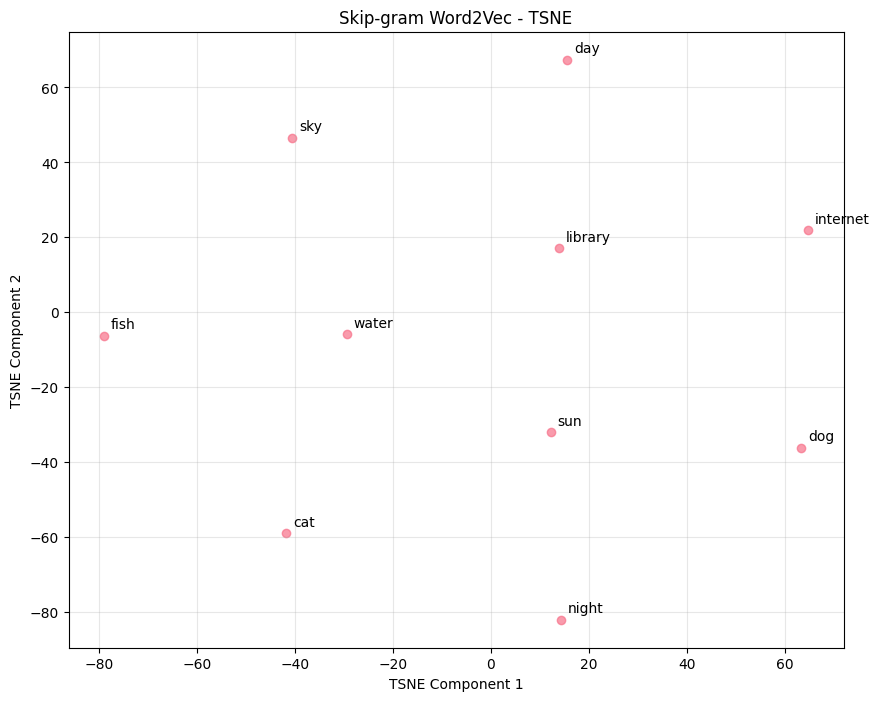


FastText Word Embeddings:


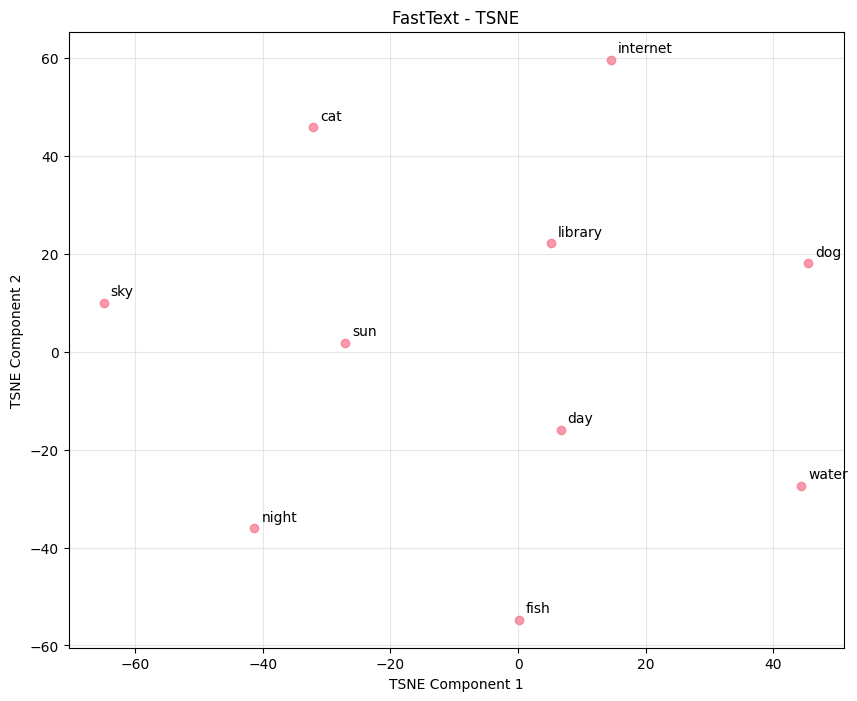


Document Embeddings Visualization:


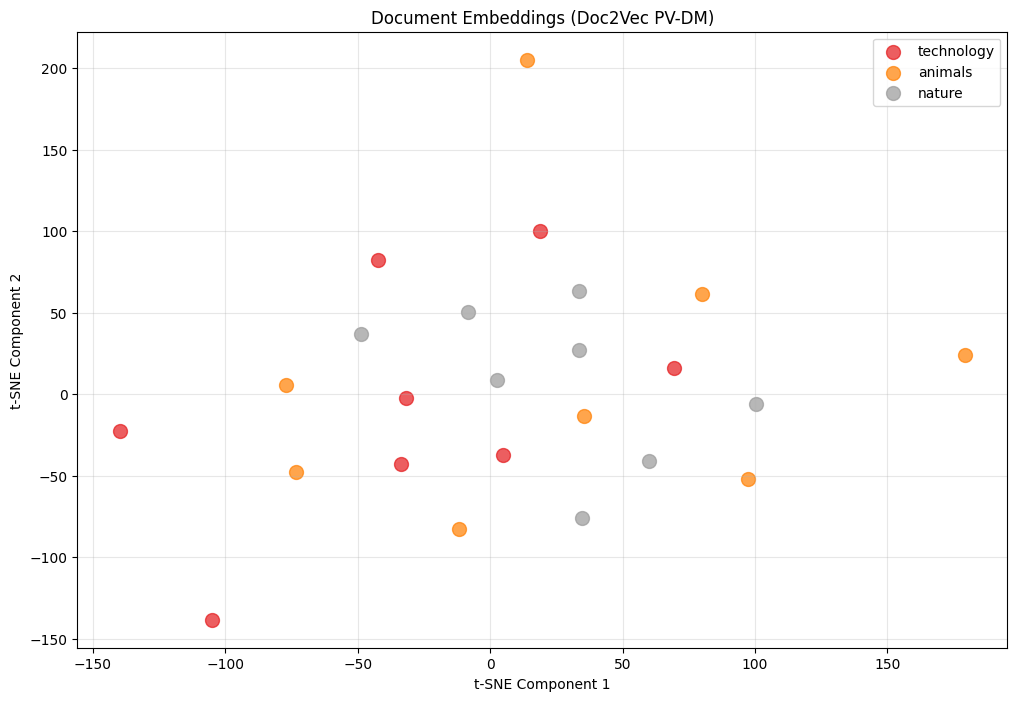


Creating similarity heatmap for: ['cat', 'dog', 'sun', 'water']


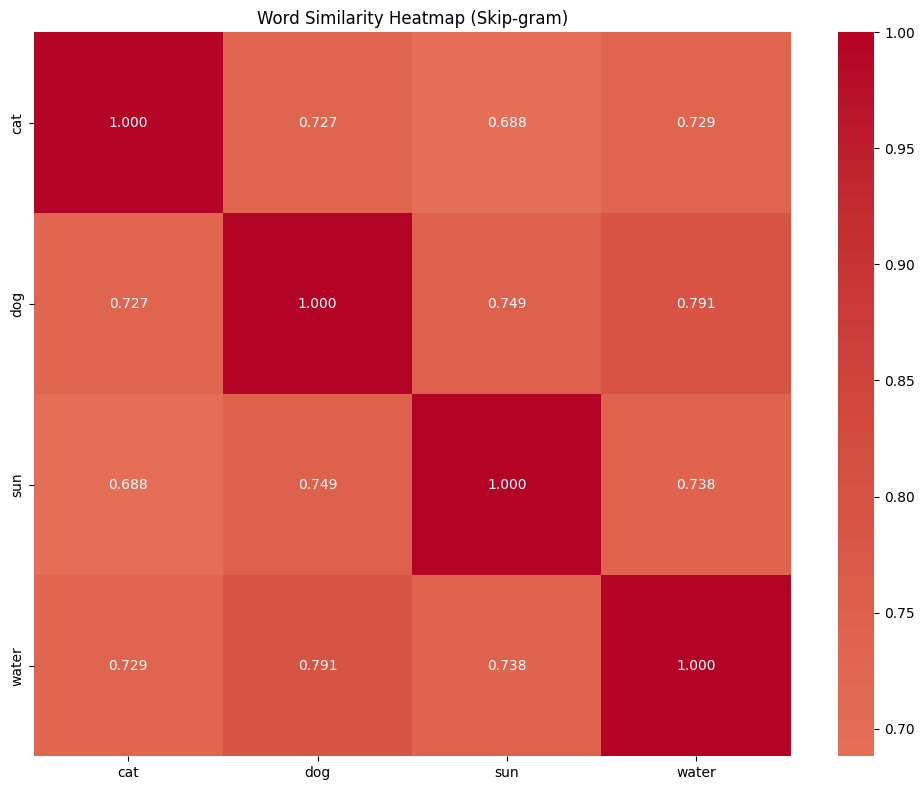

In [16]:
def visualize_embeddings(model, words, method='tsne', title="Word Embeddings"):
    """Visualize word embeddings using dimensionality reduction"""

    # Get vectors for words that exist in vocabulary
    vectors = []
    valid_words = []

    for word in words:
        if word in model.wv:
            vectors.append(model.wv[word])
            valid_words.append(word)

    if len(vectors) < 2:
        print(f"Not enough valid words for visualization ({len(vectors)} found)")
        return

    vectors = np.array(vectors)

    # Apply dimensionality reduction
    if method == 'tsne':
        if len(vectors) < 4:
            print("t-SNE requires at least 4 samples, using PCA instead")
            method = 'pca'
        else:
            reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(vectors)-1))

    if method == 'pca':
        reducer = PCA(n_components=2, random_state=42)

    reduced_vectors = reducer.fit_transform(vectors)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.7)

    # Add word labels
    for i, word in enumerate(valid_words):
        plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]),
                    xytext=(5, 5), textcoords='offset points', fontsize=10)

    plt.title(f"{title} - {method.upper()}")
    plt.xlabel(f"{method.upper()} Component 1")
    plt.ylabel(f"{method.upper()} Component 2")
    plt.grid(True, alpha=0.3)
    plt.show()

# Collect words from our vocabulary
sg_model = word2vec_models['skip-gram']
available_words = list(sg_model.wv.key_to_index.keys())

# Select interesting words for visualization
words_to_visualize = [
    'cat', 'dog', 'animals', 'bird', 'fish',
    'sun', 'moon', 'sky', 'star', 'day', 'night',
    'tree', 'flower', 'water', 'river', 'mountain',
    'computer', 'phone', 'internet', 'technology',
    'book', 'student', 'teacher', 'library',
    'car', 'plane', 'road'
]

# Filter words that exist in vocabulary
valid_words = [word for word in words_to_visualize if word in available_words]
print(f"Visualizing {len(valid_words)} words: {valid_words}")

# Visualize Skip-gram embeddings
if len(valid_words) >= 4:
    print("\nSkip-gram Word Embeddings:")
    visualize_embeddings(sg_model, valid_words, 'tsne', "Skip-gram Word2Vec")

    print("\nFastText Word Embeddings:")
    visualize_embeddings(fasttext_model, valid_words, 'tsne', "FastText")
else:
    print("Not enough words for visualization")

# Visualize document embeddings
def visualize_document_embeddings(model, texts, labels):
    """Visualize document embeddings"""

    vectors = []
    valid_labels = []

    for i, (text, label) in enumerate(zip(texts, labels)):
        doc_tag = f"{label}_{i}"
        if doc_tag in model.dv:
            vectors.append(model.dv[doc_tag])
            valid_labels.append(label)

    if len(vectors) < 4:
        print(f"Not enough documents for visualization ({len(vectors)} found)")
        return

    vectors = np.array(vectors)

    # Use t-SNE for visualization
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(vectors)-1))
    reduced_vectors = tsne.fit_transform(vectors)

    # Plot with different colors for different categories
    plt.figure(figsize=(12, 8))

    unique_labels = list(set(valid_labels))
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))

    for i, label in enumerate(unique_labels):
        mask = np.array(valid_labels) == label
        plt.scatter(reduced_vectors[mask, 0], reduced_vectors[mask, 1],
                   c=[colors[i]], label=label, alpha=0.7, s=100)

    plt.title("Document Embeddings (Doc2Vec PV-DM)")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

print("\nDocument Embeddings Visualization:")
dm_model = doc2vec_models['PV-DM']
visualize_document_embeddings(dm_model, all_categorized_texts, all_labels)

# Create embedding similarity heatmap
def create_similarity_heatmap(model, words):
    """Create similarity heatmap for words"""

    valid_words = [word for word in words if word in model.wv]

    if len(valid_words) < 2:
        print("Not enough valid words for heatmap")
        return

    # Create similarity matrix
    similarity_matrix = np.zeros((len(valid_words), len(valid_words)))

    for i, word1 in enumerate(valid_words):
        for j, word2 in enumerate(valid_words):
            if i == j:
                similarity_matrix[i][j] = 1.0
            else:
                sim = model.wv.similarity(word1, word2)
                similarity_matrix[i][j] = sim

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix,
                xticklabels=valid_words,
                yticklabels=valid_words,
                annot=True,
                cmap='coolwarm',
                center=0,
                fmt='.3f')
    plt.title("Word Similarity Heatmap (Skip-gram)")
    plt.tight_layout()
    plt.show()

# Create heatmap for selected words
heatmap_words = ['cat', 'dog', 'sun', 'moon', 'tree', 'water', 'computer', 'book']
heatmap_words = [word for word in heatmap_words if word in available_words][:8]  # Limit to 8 words

if len(heatmap_words) >= 2:
    print(f"\nCreating similarity heatmap for: {heatmap_words}")
    create_similarity_heatmap(sg_model, heatmap_words)
else:
    print("Not enough words for similarity heatmap")

## 8. Embedding Evaluation and Applications

In [17]:
# Embedding evaluation metrics
class EmbeddingEvaluator:
    """Evaluate embedding quality"""

    def __init__(self, model):
        self.model = model

    def intrinsic_evaluation(self):
        """Intrinsic evaluation of embeddings"""
        results = {}

        # Vocabulary coverage
        vocab_size = len(self.model.wv.key_to_index)
        results['vocabulary_size'] = vocab_size

        # Average vector magnitude
        all_vectors = [self.model.wv[word] for word in self.model.wv.key_to_index.keys()]
        avg_magnitude = np.mean([np.linalg.norm(vec) for vec in all_vectors])
        results['avg_vector_magnitude'] = avg_magnitude

        # Vector dimensionality
        vector_dim = self.model.wv.vector_size
        results['vector_dimensionality'] = vector_dim

        return results

    def similarity_evaluation(self, word_pairs):
        """Evaluate semantic similarity"""
        similarities = []
        valid_pairs = []

        for word1, word2 in word_pairs:
            if word1 in self.model.wv and word2 in self.model.wv:
                sim = self.model.wv.similarity(word1, word2)
                similarities.append(sim)
                valid_pairs.append((word1, word2))

        return valid_pairs, similarities

    def analogy_evaluation(self, analogies):
        """Evaluate word analogies (A:B :: C:D)"""
        correct = 0
        total = 0
        results = []

        for a, b, c, expected_d in analogies:
            if all(word in self.model.wv for word in [a, b, c, expected_d]):
                try:
                    # Find word D such that A:B :: C:D
                    predicted = self.model.wv.most_similar(
                        positive=[b, c], negative=[a], topn=1
                    )

                    predicted_d = predicted[0][0]
                    is_correct = (predicted_d == expected_d)

                    results.append({
                        'analogy': f"{a}:{b} :: {c}:{expected_d}",
                        'predicted': predicted_d,
                        'correct': is_correct
                    })

                    if is_correct:
                        correct += 1
                    total += 1

                except:
                    pass

        accuracy = correct / total if total > 0 else 0
        return accuracy, results

# Evaluate Skip-gram model
print("Embedding Evaluation:")
print("=" * 30)

sg_evaluator = EmbeddingEvaluator(sg_model)

# Intrinsic evaluation
intrinsic_results = sg_evaluator.intrinsic_evaluation()
print("Intrinsic Evaluation:")
for metric, value in intrinsic_results.items():
    print(f"  {metric}: {value}")

# Similarity evaluation
word_pairs = [
    ('cat', 'dog'),
    ('sun', 'moon'),
    ('day', 'night'),
    ('tree', 'forest'),
    ('computer', 'technology'),
    ('book', 'library'),
    ('water', 'ocean'),
    ('car', 'road')
]

valid_pairs, similarities = sg_evaluator.similarity_evaluation(word_pairs)
print(f"\nSimilarity Evaluation ({len(valid_pairs)} pairs):")
for (w1, w2), sim in zip(valid_pairs, similarities):
    print(f"  {w1:10} - {w2:10}: {sim:.3f}")

# Simple analogies (may not work well with small corpus)
analogies = [
    ('day', 'sun', 'night', 'moon'),
    ('cat', 'kitten', 'dog', 'puppy'),  # These words might not be in vocabulary
]

analogy_accuracy, analogy_results = sg_evaluator.analogy_evaluation(analogies)
print(f"\nAnalogy Evaluation (Accuracy: {analogy_accuracy:.3f}):")
for result in analogy_results:
    status = "✓" if result['correct'] else "✗"
    print(f"  {status} {result['analogy']} → {result['predicted']}")

# Application: Text Classification using embeddings
print("\n" + "=" * 50)
print("APPLICATION: TEXT CLASSIFICATION")
print("=" * 50)

def document_to_vector(doc, model, method='average'):
    """Convert document to vector using word embeddings"""
    tokens = word_tokenize(doc.lower())
    tokens = [token for token in tokens if token.isalpha() and token in model.wv]

    if not tokens:
        return np.zeros(model.wv.vector_size)

    if method == 'average':
        vectors = [model.wv[token] for token in tokens]
        return np.mean(vectors, axis=0)
    elif method == 'sum':
        vectors = [model.wv[token] for token in tokens]
        return np.sum(vectors, axis=0)

    return np.zeros(model.wv.vector_size)

# Prepare classification data
X_embeddings = []
y_labels = []

for text, label in zip(all_categorized_texts, all_labels):
    vector = document_to_vector(text, sg_model, 'average')
    if np.any(vector):  # Only include if vector is not all zeros
        X_embeddings.append(vector)
        y_labels.append(label)

X_embeddings = np.array(X_embeddings)
print(f"Classification dataset: {X_embeddings.shape[0]} documents, {X_embeddings.shape[1]} features")
print(f"Classes: {set(y_labels)}")

if X_embeddings.shape[0] > 6:  # Need enough samples for train/test split
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_embeddings, y_labels, test_size=0.3, random_state=42, stratify=y_labels
    )

    # Train classifier
    classifier = LogisticRegression(random_state=42, max_iter=1000)
    classifier.fit(X_train, y_train)

    # Evaluate
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\nClassification Results:")
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"Accuracy: {accuracy:.3f}")

    # Detailed report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Test with new document
    new_test_doc = "The artificial intelligence system processes information rapidly."
    new_vector = document_to_vector(new_test_doc, sg_model, 'average')

    if np.any(new_vector):
        predicted_class = classifier.predict([new_vector])[0]
        prediction_proba = classifier.predict_proba([new_vector])[0]

        print(f"\nNew document classification:")
        print(f"Document: {new_test_doc}")
        print(f"Predicted class: {predicted_class}")
        print(f"Class probabilities:")
        for class_name, prob in zip(classifier.classes_, prediction_proba):
            print(f"  {class_name}: {prob:.3f}")
else:
    print("Not enough samples for classification")

# Compare different vectorization methods
print("\n" + "=" * 50)
print("VECTORIZATION METHOD COMPARISON")
print("=" * 50)

comparison_methods = {
    'TF-IDF': TfidfVectorizer(max_features=100, stop_words='english'),
    'Word2Vec_avg': lambda texts: np.array([document_to_vector(text, sg_model, 'average') for text in texts]),
    'FastText_avg': lambda texts: np.array([document_to_vector(text, fasttext_model, 'average') for text in texts])
}

method_results = {}

for method_name, vectorizer in comparison_methods.items():
    try:
        if method_name == 'TF-IDF':
            X = vectorizer.fit_transform(all_categorized_texts).toarray()
        else:
            X = vectorizer(all_categorized_texts)

        # Filter out zero vectors
        non_zero_mask = np.any(X != 0, axis=1)
        X_filtered = X[non_zero_mask]
        y_filtered = [all_labels[i] for i, mask in enumerate(non_zero_mask) if mask]

        if len(X_filtered) > 6:
            # Train and evaluate
            X_train, X_test, y_train, y_test = train_test_split(
                X_filtered, y_filtered, test_size=0.3, random_state=42
            )

            clf = LogisticRegression(random_state=42, max_iter=1000)
            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)

            method_results[method_name] = {
                'accuracy': accuracy,
                'samples': len(X_filtered),
                'features': X_filtered.shape[1]
            }

    except Exception as e:
        print(f"Error with {method_name}: {e}")

# Display comparison results
if method_results:
    print("Method Comparison Results:")
    print(f"{'Method':<15} {'Accuracy':<10} {'Samples':<10} {'Features':<10}")
    print("-" * 50)

    for method, results in method_results.items():
        print(f"{method:<15} {results['accuracy']:<10.3f} {results['samples']:<10} {results['features']:<10}")
else:
    print("No comparison results available")

Embedding Evaluation:
Intrinsic Evaluation:
  vocabulary_size: 113
  avg_vector_magnitude: 0.1248500719666481
  vector_dimensionality: 100

Similarity Evaluation (3 pairs):
  cat        - dog       : 0.727
  day        - night     : 0.738
  water      - ocean     : 0.825

Analogy Evaluation (Accuracy: 0.000):

APPLICATION: TEXT CLASSIFICATION
Classification dataset: 20 documents, 100 features
Classes: {'technology', 'animals', 'nature'}

Classification Results:
Training samples: 14
Test samples: 6
Accuracy: 0.333

Classification Report:
              precision    recall  f1-score   support

     animals       0.00      0.00      0.00         3
      nature       0.33      1.00      0.50         2
  technology       0.00      0.00      0.00         1

    accuracy                           0.33         6
   macro avg       0.11      0.33      0.17         6
weighted avg       0.11      0.33      0.17         6


New document classification:
Document: The artificial intelligence system p

---

# Challenge Section

Complete these challenges to master word embeddings and text vectorization!

### Challenge 1: Custom Similarity Metrics

Implement different similarity metrics for comparing embeddings.

**Tasks:**
1. Implement Manhattan distance
2. Implement Euclidean distance  
3. Implement Jaccard similarity for binary vectors
4. Compare different metrics on the same word pairs

In [9]:
# TODO: Implement custom similarity metrics
import math

class SimilarityMetrics:
    @staticmethod
    def manhattan_distance(vec1, vec2):
        """
        Calculate Manhattan (L1) distance between two vectors
        """
        return sum(abs(a - b) for a, b in zip(vec1, vec2))

    @staticmethod
    def euclidean_distance(vec1, vec2):
        """
        Calculate Euclidean (L2) distance between two vectors
        """
        return math.sqrt(sum((a - b) ** 2 for a, b in zip(vec1, vec2)))

    @staticmethod
    def jaccard_similarity(vec1, vec2, threshold=0.0):
        """
        Calculate Jaccard similarity for binary/sparse vectors.
        If `threshold` > 0.0, converts to binary using that threshold.
        """
        if threshold > 0.0:
            vec1 = [1 if x > threshold else 0 for x in vec1]
            vec2 = [1 if x > threshold else 0 for x in vec2]

        set1 = set(i for i, val in enumerate(vec1) if val)
        set2 = set(i for i, val in enumerate(vec2) if val)

        intersection = len(set1 & set2)
        union = len(set1 | set2)

        return intersection / union if union != 0 else 0.0

    @staticmethod
    def compare_metrics(vec1, vec2):
        """
        Compare all similarity metrics
        """
        manhattan = SimilarityMetrics.manhattan_distance(vec1, vec2)
        euclidean = SimilarityMetrics.euclidean_distance(vec1, vec2)
        jaccard = SimilarityMetrics.jaccard_similarity(vec1, vec2)

        return {
            "manhattan_distance": manhattan,
            "euclidean_distance": euclidean,
            "jaccard_similarity": jaccard
        }


# Test your implementations
print("Challenge L1: Implement custom similarity metrics")
vec_a = [1, 2, 3, 0]
vec_b = [2, 2, 0, 1]

results = SimilarityMetrics.compare_metrics(vec_a, vec_b)
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")


Challenge L1: Implement custom similarity metrics
manhattan_distance: 5.0000
euclidean_distance: 3.3166
jaccard_similarity: 0.5000


### Challenge 2: Embedding Arithmetic Explorer

Create an interactive tool for exploring word arithmetic with embeddings.

**Tasks:**
1. Build function to perform word arithmetic (A - B + C)
2. Create batch arithmetic operations
3. Visualize arithmetic results
4. Test famous examples (king - man + woman ≈ queen)


=== Test 1: Simple Arithmetic ===
queen: 0.7699
monarch: 0.6843
throne: 0.6756
daughter: 0.6595
princess: 0.6521

=== Test 2: Batch Arithmetic ===

['king', 'woman'] - ['man'] = ? (Expected: queen)
queen: 0.7699
monarch: 0.6843
throne: 0.6756
daughter: 0.6595
princess: 0.6521

['paris', 'italy'] - ['france'] = ? (Expected: rome)
rome: 0.8190
milan: 0.7376
naples: 0.7118
venice: 0.7015
turin: 0.6995

=== Test 3: Visualization ===


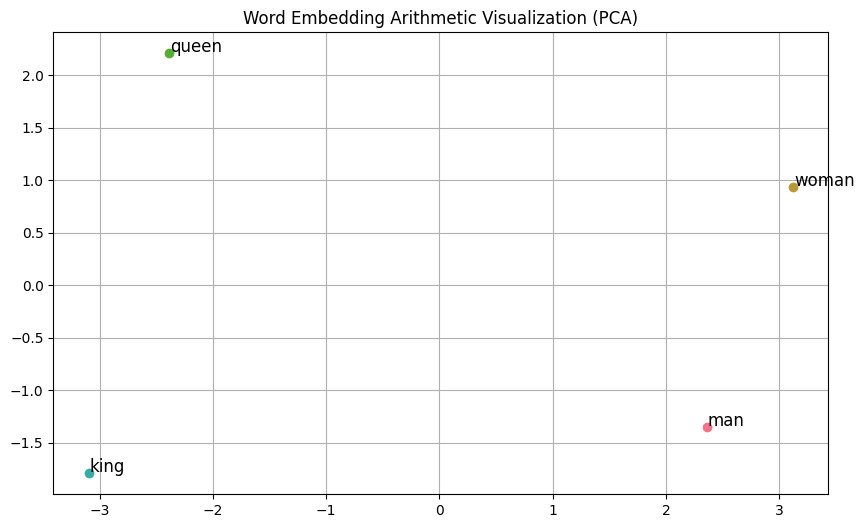

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

class EmbeddingArithmetic:
    def __init__(self, model):
        self.model = model

    def word_arithmetic(self, positive_words, negative_words, topn=5):
    
        try:
            return self.model.most_similar(positive=positive_words, negative=negative_words, topn=topn)
        except KeyError as e:
            print(f"Word not in vocabulary: {e}")
            return []

    def batch_arithmetic(self, arithmetic_examples):
        
        results = []
        for positive, negative, expected in arithmetic_examples:
            matches = self.word_arithmetic(positive, negative)
            results.append({
                'positive': positive,
                'negative': negative,
                'expected': expected,
                'top_matches': matches
            })
        return results

    def visualize_arithmetic(self, positive_words, negative_words, result_words):
        
        words = list(set(positive_words + negative_words + result_words))
        vectors, labels = [], []

        for word in words:
            if word in self.model:
                vectors.append(self.model[word])
                labels.append(word)

        if len(vectors) < 2:
            print("Not enough words to visualize.")
            return

        reduced = PCA(n_components=2).fit_transform(vectors)

        plt.figure(figsize=(10, 6))
        for (x, y), label in zip(reduced, labels):
            plt.scatter(x, y)
            plt.text(x + 0.01, y + 0.01, label, fontsize=12)

        plt.title("Word Embedding Arithmetic Visualization (PCA)")
        plt.grid(True)
        plt.show()


if __name__ == "__main__":
    from gensim.downloader import load
    model = load("glove-wiki-gigaword-100")

    arithmetic_explorer = EmbeddingArithmetic(model)

    print("\nTest 1: Simple Arithmetic")
    result = arithmetic_explorer.word_arithmetic(["king", "woman"], ["man"])
    for word, score in result:
        print(f"{word}: {score:.4f}")

    print("\Test 2: Batch Arithmetic")
    examples = [
        (["king", "woman"], ["man"], "queen"),
        (["paris", "italy"], ["france"], "rome"),
    ]
    for res in arithmetic_explorer.batch_arithmetic(examples):
        print(f"\n{res['positive']} - {res['negative']} = ? (Expected: {res['expected']})")
        for word, score in res["top_matches"]:
            print(f"{word}: {score:.4f}")

    print("\n=== Test 3: Visualization ===")
    arithmetic_explorer.visualize_arithmetic(["king", "woman"], ["man"], ["queen"])


### Challenge 3: Embedding Quality Dashboard

Create a comprehensive dashboard for evaluating embedding quality.

**Tasks:**
1. Implement vocabulary coverage analysis
2. Create embedding density/sparsity metrics
3. Build similarity distribution analysis
4. Generate comprehensive quality report

In [22]:
# TODO: Implement embedding quality dashboard
class EmbeddingQualityDashboard:
    def __init__(self, model):
        self.model = model

    def vocabulary_coverage_analysis(self, test_corpus):
        """
        Analyze what percentage of test corpus words are covered
        """
        # Your implementation here
        pass

    def embedding_density_metrics(self):
        """
        Calculate sparsity and density of embeddings
        """
        # Your implementation here
        pass

    def similarity_distribution_analysis(self, sample_size=1000):
        """
        Analyze distribution of similarities between random word pairs
        """
        # Your implementation here
        pass

    def generate_quality_report(self, test_corpus=None):
        """
        Generate comprehensive quality report with visualizations
        """
        # Your implementation here
        pass

print("Challenge L3: Implement embedding quality dashboard")

Challenge L3: Implement embedding quality dashboard


### Challenge 4: Custom Word2Vec Implementation

Implement a simplified version of Word2Vec from scratch.

**Tasks:**
1. Implement Skip-gram with negative sampling
2. Create vocabulary building with frequency filtering
3. Implement training loop with gradient descent
4. Compare results with Gensim's Word2Vec

In [21]:
# TODO: Implement custom Word2Vec
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class Word2VecDataset(Dataset):
    def __init__(self, corpus, window_size=5, negative_samples=5):
        """
        Create dataset for Word2Vec training
        """
        # Your implementation here
        pass

    def __len__(self):
        # Your implementation here
        pass

    def __getitem__(self, idx):
        # Your implementation here
        pass

class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        """
        Implement Skip-gram model architecture
        """
        # Your implementation here
        pass

    def forward(self, center_word, context_words, negative_words):
        # Your implementation here
        pass

class CustomWord2Vec:
    def __init__(self, embedding_dim=100, window_size=5, negative_samples=5):
        self.embedding_dim = embedding_dim
        self.window_size = window_size
        self.negative_samples = negative_samples

    def train(self, corpus, epochs=100, lr=0.001):
        """
        Train the Word2Vec model
        """
        # Your implementation here
        pass

    def get_word_vector(self, word):
        """
        Get vector for a word
        """
        # Your implementation here
        pass

    def most_similar(self, word, topn=5):
        """
        Find most similar words
        """
        # Your implementation here
        pass

print("Challenge M1: Implement custom Word2Vec")

Challenge M1: Implement custom Word2Vec


### Challenge 5: Multi-language Embedding Alignment

Align embeddings across different languages.

**Tasks:**
1. Create bilingual word pairs dataset
2. Implement Procrustes alignment
3. Evaluate cross-lingual similarity
4. Build translation using aligned embeddings

In [22]:
# TODO: Implement multi-language embedding alignment
from scipy.linalg import orthogonal_procrustes

class CrossLingualEmbeddings:
    def __init__(self, source_embeddings, target_embeddings):
        self.source_embeddings = source_embeddings
        self.target_embeddings = target_embeddings
        self.alignment_matrix = None

    def create_bilingual_pairs(self, word_pairs):
        """
        Create training pairs for alignment
        word_pairs: list of (source_word, target_word) tuples
        """
        # Your implementation here
        pass

    def procrustes_alignment(self, source_vectors, target_vectors):
        """
        Learn alignment matrix using Procrustes analysis
        """
        # Your implementation here
        pass

    def align_embeddings(self, bilingual_pairs):
        """
        Align source embeddings to target space
        """
        # Your implementation here
        pass

    def translate_word(self, source_word, topn=5):
        """
        Translate word using aligned embeddings
        """
        # Your implementation here
        pass

    def evaluate_alignment(self, test_pairs):
        """
        Evaluate alignment quality on test pairs
        """
        # Your implementation here
        pass

print("Challenge M2: Implement multi-language embedding alignment")

Challenge M2: Implement multi-language embedding alignment


### Challenge 6: Dynamic Embedding Updates

Implement online learning for embeddings with new vocabulary.

**Tasks:**
1. Implement incremental vocabulary expansion
2. Create online embedding updates
3. Handle concept drift in embeddings
4. Evaluate stability vs. adaptability trade-off

In [23]:
# TODO: Implement dynamic embedding updates
class DynamicEmbeddings:
    def __init__(self, base_model, update_rate=0.01, stability_factor=0.9):
        self.base_model = base_model
        self.update_rate = update_rate
        self.stability_factor = stability_factor
        self.embedding_history = {}

    def add_new_vocabulary(self, new_words, context_sentences):
        """
        Add new words to vocabulary incrementally
        """
        # Your implementation here
        pass

    def online_update(self, new_sentences, batch_size=32):
        """
        Update embeddings with new sentences online
        """
        # Your implementation here
        pass

    def detect_concept_drift(self, words_to_monitor, threshold=0.1):
        """
        Detect if word meanings have drifted significantly
        """
        # Your implementation here
        pass

    def adaptive_update_strategy(self, word, new_vector):
        """
        Adaptively update embeddings based on confidence and drift
        """
        # Your implementation here
        pass

    def evaluate_stability(self, test_words, num_updates=10):
        """
        Evaluate how stable embeddings are over updates
        """
        # Your implementation here
        pass

print("Challenge M3: Implement dynamic embedding updates")

Challenge M3: Implement dynamic embedding updates


### Challenge 7: Contextual Embeddings from Scratch

Implement a simplified contextual embedding model.

**Tasks:**
1. Build bidirectional LSTM for context
2. Implement attention mechanism
3. Create context-dependent word representations
4. Compare with static embeddings on polysemy

In [24]:
# TODO: Implement contextual embeddings
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContextualEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2):
        super(ContextualEmbedding, self).__init__()
        """
        Implement contextual embedding model
        """
        # Your implementation here
        pass

    def forward(self, input_ids, attention_mask=None):
        """
        Forward pass to get contextual embeddings
        """
        # Your implementation here
        pass

class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        """
        Implement attention mechanism
        """
        # Your implementation here
        pass

    def forward(self, hidden_states, attention_mask=None):
        # Your implementation here
        pass

class ContextualEmbeddingTrainer:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def train(self, corpus, epochs=10, batch_size=32):
        """
        Train contextual embedding model
        """
        # Your implementation here
        pass

    def get_contextual_embedding(self, sentence, word_index):
        """
        Get contextual embedding for specific word in sentence
        """
        # Your implementation here
        pass

    def evaluate_polysemy(self, polysemous_words, contexts):
        """
        Evaluate how well model handles polysemous words
        """
        # Your implementation here
        pass

print("Challenge H1: Implement contextual embeddings")

Challenge H1: Implement contextual embeddings


### Challenge 8: Embedding Space Analysis and Manipulation

Deep analysis and manipulation of embedding spaces.

**Tasks:**
1. Implement embedding space clustering
2. Create semantic subspace identification
3. Build embedding space transformations
4. Develop embedding space quality metrics

In [25]:
# TODO: Implement embedding space analysis
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

class EmbeddingSpaceAnalyzer:
    def __init__(self, embeddings, vocab):
        self.embeddings = embeddings
        self.vocab = vocab

    def cluster_embedding_space(self, method='kmeans', n_clusters=10):
        """
        Cluster words in embedding space
        """
        # Your implementation here
        pass

    def identify_semantic_subspaces(self, semantic_categories):
        """
        Identify subspaces corresponding to semantic categories
        """
        # Your implementation here
        pass

    def analyze_embedding_geometry(self):
        """
        Analyze geometric properties of embedding space
        - Dimensionality
        - Isotropy
        - Local density
        """
        # Your implementation here
        pass

    def find_semantic_directions(self, word_pairs):
        """
        Find directions in space corresponding to semantic relations
        """
        # Your implementation here
        pass

class EmbeddingSpaceManipulator:
    def __init__(self, embeddings, vocab):
        self.embeddings = embeddings
        self.vocab = vocab

    def debias_embeddings(self, bias_direction, words_to_debias):
        """
        Remove bias from embeddings along specified direction
        """
        # Your implementation here
        pass

    def retrofit_embeddings(self, semantic_constraints):
        """
        Retrofit embeddings using semantic constraints
        """
        # Your implementation here
        pass

    def compress_embeddings(self, target_dim, method='pca'):
        """
        Compress embeddings to lower dimensions
        """
        # Your implementation here
        pass

    def enhance_embedding_isotropy(self):
        """
        Make embedding space more isotropic
        """
        # Your implementation here
        pass

print("Challenge H2: Implement embedding space analysis and manipulation")

Challenge H2: Implement embedding space analysis and manipulation


### Challenge 9: Hybrid Embedding Architecture

Create a hybrid system combining multiple embedding approaches.

**Tasks:**
1. Combine static and contextual embeddings
2. Integrate character and word-level information
3. Implement adaptive embedding selection
4. Build multi-granularity embeddings

In [26]:
# TODO: Implement hybrid embedding architecture
class HybridEmbeddingSystem:
    def __init__(self):
        self.static_embeddings = None
        self.contextual_model = None
        self.char_embeddings = None
        self.fusion_weights = None

    def initialize_components(self, vocab_size, embedding_dim):
        """
        Initialize all embedding components
        """
        # Your implementation here
        pass

    def adaptive_embedding_selection(self, word, context, selection_criteria):
        """
        Adaptively select which embedding to use based on criteria
        """
        # Your implementation here
        pass

    def multi_granularity_fusion(self, word, context):
        """
        Combine character, subword, word, and context embeddings
        """
        # Your implementation here
        pass

    def dynamic_fusion_weights(self, word_properties, context_properties):
        """
        Dynamically determine fusion weights based on properties
        """
        # Your implementation here
        pass

    def train_fusion_network(self, training_data, downstream_task):
        """
        Train fusion network for specific downstream task
        """
        # Your implementation here
        pass

    def evaluate_hybrid_system(self, test_data, baselines):
        """
        Comprehensive evaluation against baseline methods
        """
        # Your implementation here
        pass

class MetaEmbeddingLearner:
    def __init__(self, embedding_sources):
        self.embedding_sources = embedding_sources

    def learn_optimal_combination(self, validation_data, task_type):
        """
        Learn optimal way to combine different embedding sources
        """
        # Your implementation here
        pass

    def transfer_combination_strategy(self, source_task, target_task):
        """
        Transfer learned combination strategy to new task
        """
        # Your implementation here
        pass

print("Challenge H3: Implement hybrid embedding architecture")

Challenge H3: Implement hybrid embedding architecture
